In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats

import matplotlib.colors as colors


import os
import joblib
import pickle
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from joblib import dump


from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)
from sklearn.inspection import plot_partial_dependence

sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
import plot_helpers

In [3]:
## Load training data

def load_data(train_val='train'):
    assert isinstance(train_val, str) and train_val in ['train', 'val'], "train_val should be a string and must be either 'train' or 'val'"
    
    monthlist = ['DEC17','JAN18','FEB18','MAR18','APR18','MAY18','JUN18','JUL18','AUG18','SEP18','OCT18','NOV18']
    path = '/net/helium/atmosdyn/freimax/data_msc/IFS-18/cyclones/data_random_forest'

    list_df_1month = []
    for month in monthlist:
        list_df_1month.append(pd.read_pickle(f'{path}/{month}/df_ifs_masked_{train_val}.pkl'))

    # Concatenate all dataframes in the list into a single dataframe
    print('Concatente all df to one')
    df = pd.concat(list_df_1month, ignore_index=True)

    # Cancel unallowed values (coolin rate positve)
    df[df['tmeltsi']>0] = 0
    df[df['tsubsi']>0] = 0
    df[df['tevr']>0] = 0

    return df

df_train = load_data('train')
df_val = load_data('val')

Concatente all df to one
Concatente all df to one


In [4]:
## Drop unnecessary columns
cols_target_features = ['tsubsi', 'SIWC', 'LWC', 'RWC', 'RH', 'Q', 'OMEGA', 'T']

df_train = df_train[cols_target_features]
df_val = df_val[cols_target_features]


In [5]:
print(df_train.shape)
print(df_val.shape)

(99952833, 8)
(14438680, 8)


In [6]:
# Old df_train.shape and 
# (138658804, 7)    (old)
# ( 99952833, 7)    (new)

# df_val.shape
# (14548323, 7)     (old)
# (14438680, 7)     (new)

In [7]:
df_train.describe()

,tsubsi,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07
mean,-6.435961e-03,6.646162e-03,2.504825e-03,6.648872e-04,1.274297e+01,3.822144e-04,-1.977584e-02,-1.104258e+01
std,5.293139e-02,4.433433e-02,1.935200e-02,9.133182e-03,2.570297e+01,1.276379e-03,1.570743e-01,1.916656e+01
min,-8.727828e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.261989e+01,-9.121857e+01
25%,-1.316221e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.286819e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.414006e+00,3.436481e-06,0.000000e+00,0.000000e+00
max,0.000000e+00,6.370396e+00,1.511991e+00,2.368629e+00,1.362414e+02,2.178455e-02,9.686302e+00,4.174277e+01


In [9]:
df_tsubsi_train = rf_functions.apply_domainfilter(df=df_train,
                                                  water_type='SIWC',
                                                  verbose=1,
                                                  temp_filter=False,
                                                  output_filter=False)

Drop all points where SIWC == 0


In [11]:
df_tsubsi_val = rf_functions.apply_domainfilter(df=df_val,
                                                water_type='SIWC',
                                                verbose=1,
                                                temp_filter=False,output_filter=False)

Drop all points where SIWC == 0


In [12]:
# Define the predictors and the target
target = 'tsubsi'

X_train = df_tsubsi_train.drop([target], axis=1)
y_train = df_tsubsi_train[target]

X_val = df_tsubsi_val.drop([target], axis=1)
y_val = df_tsubsi_val[target]

In [13]:
df_train[X_train.columns].describe()

,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07,9.995283e+07
mean,6.646162e-03,2.504825e-03,6.648872e-04,1.274297e+01,3.822144e-04,-1.977584e-02,-1.104258e+01
std,4.433433e-02,1.935200e-02,9.133182e-03,2.570297e+01,1.276379e-03,1.570743e-01,1.916656e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.261989e+01,-9.121857e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.286819e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,2.414006e+00,3.436481e-06,0.000000e+00,0.000000e+00
max,6.370396e+00,1.511991e+00,2.368629e+00,1.362414e+02,2.178455e-02,9.686302e+00,4.174277e+01


In [14]:
X_train.describe()

,SIWC,LWC,RWC,RH,Q,OMEGA,T
count,1.323855e+07,1.323855e+07,1.323855e+07,1.323855e+07,1.323855e+07,1.323855e+07,1.323855e+07
mean,5.017941e-02,1.314088e-02,1.229008e-03,6.751574e+01,1.507418e-03,-1.270487e-01,-2.177184e+01
std,1.100689e-01,3.968003e-02,1.016874e-02,2.131294e+01,1.471829e-03,3.702755e-01,1.929493e+01
min,2.328306e-07,0.000000e+00,0.000000e+00,9.026296e-03,1.000000e-08,-1.261989e+01,-9.121857e+01
25%,1.624227e-03,0.000000e+00,0.000000e+00,5.849584e+01,2.036415e-04,-2.322335e-01,-3.723847e+01
50%,1.105666e-02,0.000000e+00,0.000000e+00,7.147710e+01,1.015641e-03,-6.120729e-02,-1.774303e+01
75%,4.823878e-02,2.279878e-03,0.000000e+00,8.570238e+01,2.752327e-03,3.896618e-02,-4.349579e+00
max,6.370396e+00,1.510561e+00,1.912534e+00,1.362414e+02,1.179238e-02,7.495474e+00,1.481607e+01


In [15]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

In [16]:
model_name = 'rf_fulldata_gridsearch'
filepath = f"/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tsubsi/{model_name}.joblib"


if os.path.isfile(filepath) or input('Rerun model? (y/n)') == 'n':
    print('Load Model')
    path = f'/net/helium/atmosdyn/freimax/data_msc/IFS-18/rf_models/tsubsi/{model_name}_f1.joblib'
    best_model_f1 = joblib.load(f'{path}')
else:
    doublecheck = input('Do you want to run the model?  (yes/no)')
    if doublecheck == 'yes':
        # Define the hyperparameters for grid search

        param_grid = {
            'n_estimators'      : [500],
            'max_depth'         : [200],
            'max_features'      : [3],
            'min_samples_split' : [4,6],
            'min_samples_leaf'  : [20],
            'criterion'         : ['squared_error']
        }

        # Call the function
        best_model_mse, best_params_mse, best_model_f1, best_params_f1 = rf_functions.grid_search_with_validation_set_f1(X_train=X_train,
                                                                                                                         y_train=y_train,
                                                                                                                         X_val=X_val,
                                                                                                                         y_val=y_val,
                                                                                                                         param_grid=param_grid,
                                                                                                                         save_name=model_name, 
                                                                                                                         threshold=-0.1
                                                                                                                         )

Load Model


In [57]:
best_model_f1

RandomForestRegressor(max_depth=200, max_features=3, min_samples_leaf=20,
                      min_samples_split=4, n_estimators=500, n_jobs=60)

In [17]:
y_pred = best_model_f1.predict(X_val)

residuals = y_val - y_pred
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

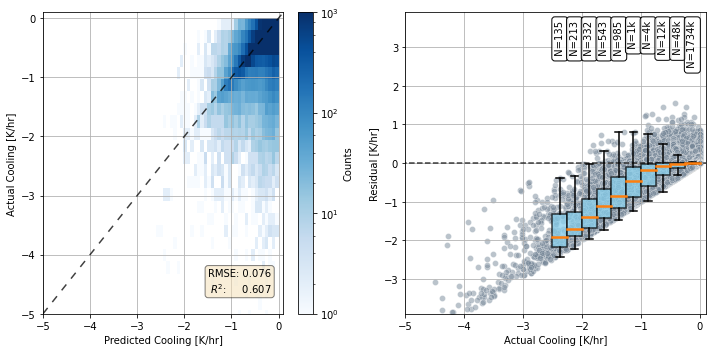

In [18]:
xrange = -5
yrange = 3.9

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_pred, y_val, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Predicted Cooling [K/hr]')
ax[0].set_ylabel('Actual Cooling [K/hr]')
ax[0].set_xlim(xrange, 0.1)
ax[0].set_ylim(xrange, 0.1)
ax[0].plot([-5,1], [-5,1], linewidth=1.5, c='k', linestyle='--', dashes=(5,5), alpha=0.75)

# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Counts')
# Set logarithmic colorbar ticks 
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.3f}\n$R^2$:     {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.95, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           ha='right', va='top', bbox=props)
ax[0].grid(zorder=0)
# Create a scatter plot of residuals
sns.scatterplot(x=y_val, y=residuals, alpha=0.5, color='lightslategray', ax=ax[1])
ax[1].set_ylabel('Residual [K/hr]')
ax[1].set_xlabel('Actual Cooling [K/hr]')
ax[1].set_xlim(xrange, 0.1)
ax[1].set_ylim(-yrange, yrange)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k', alpha=0.75,  linewidth=1.5) 
plot_helpers.add_boxplots(x=y_val,y=residuals, ax=ax[1], width_boxplot=0.25, min_points_boxplot=100, count_per_boxplot=True, fontsize_text=10, input_detail_mode=False)
plt.tight_layout()
plt.grid(zorder=0)
# plt.savefig(f'/home/freimax/msc_thesis/figures/thesis_msc/Chapter_RandomForest/tsubsi_predVStrue_resid.png',dpi=200)

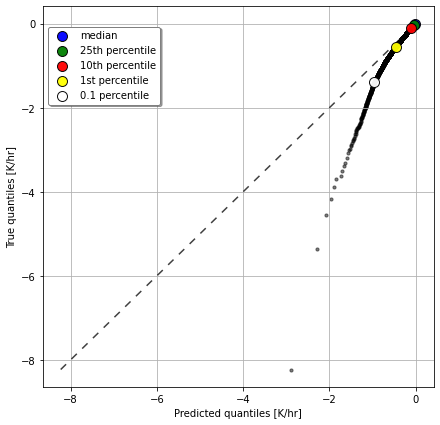

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
nr_points = plot_helpers.plot_modified_qq_plot(ax=ax, y_pred=y_pred, y_true=y_val, subsample_factor=0.1)
plt.show()


In [34]:
ax.get_ylim()

(-8.639517831802369, 0.41140561103820805)

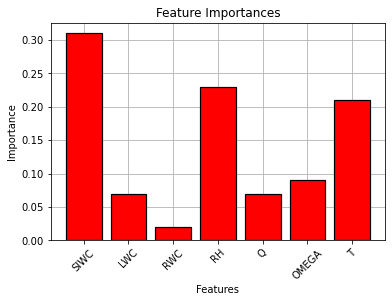

In [56]:
# Get numerical feature importances
importances = list(best_model_f1.feature_importances_)

# List of tuples with variable and importance and sort them
feature_list = list(X_train.columns) 
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# list of x locations for plotting
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

x_values = list(range(len(importances)))# Make a bar chart
plt.grid(zorder=0)
plt.bar(x_values, sorted_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2, zorder=2)
plt.xticks(x_values, sorted_features, rotation=45)# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Feature Importances')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tsubsi_feat_imp'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')

In [35]:
feature_indices = [feature_list.index(feature) for feature in ['SIWC','RH','T']] 
feature_indices

[0, 3, 6]

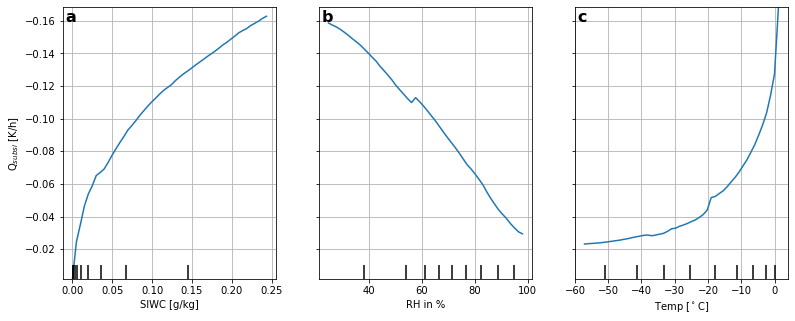

In [54]:
xlabel_list = ['SIWC [g/kg]', 'RH in %', r'Temp [$^\circ$C]']

fig,axs = plt.subplots(nrows=1,ncols=3, figsize=(13,5), sharey=True)
imgs = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_indices, grid_resolution=50, ax=axs, )

axs[0].set_ylabel(r'Q$_{subsi}$ [K/h]')
for i in range(3):
    if i !=0:
        axs[i].set_ylabel('')
    axs[i].set_xlabel(xlabel_list[i])
    axs[i].invert_yaxis()


## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tsubsi_pdp_single'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
from itertools import combinations

# Generating all possible combinations of 2 features from the list of 7 features
feature_combinations = list(combinations(feature_indices, 2))
feature_combinations 

[(0, 3), (0, 6), (3, 6)]

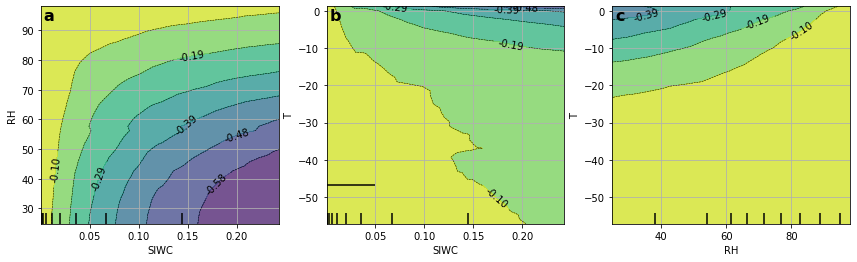

In [49]:
if len(feature_combinations)<=3:
    cols = int(len(feature_combinations))
    fig,axs=plt.subplots(ncols=cols, figsize=(4.5*cols+1,4))
else:
    cols = len(feature_combinations) // 2
    rows = len(feature_combinations) - cols
    fig,axs=plt.subplots(nrows=int(rows), ncols=int(cols), figsize=(5*cols,5*rows))

imgs2d = PartialDependenceDisplay.from_estimator(best_model_f1, X_train, feature_combinations, ax=axs,
                                        grid_resolution=50, feature_names=feature_list)

## Add label and grid for every plot
labels = ['a','b','c']
for col in range(len(labels)):
    axs[col].grid(zorder=1)
    label= labels[col]
    axs[col].text(0.012, 0.99, label, transform=axs[col].transAxes, fontsize=16, fontweight='bold', va='top')

save_path='/home/freimax/msc_thesis/figures/thesis_msc/appendix/'
filename = f'tsubsi_pdp_2feat'  
plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# features = [0, 1, (0, 1)]
# PartialDependenceDisplay.from_estimator(best_model_f1, X_val, features, target=0)

[(0, 3), (0, 6), (0, 5), (3, 6), (3, 5), (6, 5)]

In [44]:
# # Plotting 2D PDP for feature combinations
# for feature_pair in feature_combinations:
#     print(feature_pair)
#     PartialDependenceDisplay.from_estimator(best_model_f1, X_train, [feature_pair], grid_resolution=50, feature_names=feature_list)
#     plt.suptitle(f'PDP for Interaction: {feature_list[feature_pair[0]]} and {feature_list[feature_pair[1]]}')
#     plt.subplots_adjust(top=0.9)  # Adjust title position
#     plt.show()

---
---
---
## Here follow old tires (especxially with log transform and SMOGN -> Not relevant anymore)

### Set threshold to data and calculate using smogn

In [34]:
thr_list = [-0.0001, -0.001, -0.01, -0.1, -0.25, -0.5]

fraction_of_df = []
fraction_df_train = []
for thr in thr_list:
    fraction_of_df.append(df_train[df_train.tsubsi <= thr].shape[0] / df_train.shape[0])
    fraction_df_train.append(df_tsubsi_train[df_tsubsi_train.tsubsi <= thr].shape[0] / df_tsubsi_train.shape[0])

---
---
## Try Regression model after classification model

### These are old tries that turned out o be little promising
---

In [17]:
def apply_cooling_thr(X,y, thr):
    X_cutoff = X[y <= thr]
    y_cutoff = y[y <= thr]
    assert X_cutoff.shape[0] == y_cutoff.shape[0]
    print(f'New shape:\t{X_cutoff.shape }\nOld shape:\t{X.shape}')
    return X_cutoff, y_cutoff

In [18]:
tsubsi_thr = -0.001

print('Training Set')
X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, tsubsi_thr)
print('Validation Set')
X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, tsubsi_thr)

Training Set
New shape:	(36465512, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(4007998, 5)
Old shape:	(6024117, 5)


In [23]:
# Define the hyperparameters for grid search
param_grid = {
    'n_estimators': [500],
    'max_depth': [30],
    'max_features': [3],
    'min_samples_split': [40],
    'min_samples_leaf':[1],
    'criterion': ['squared_error']
}

cutoff_models = []
cutoff_best_params = []
thr_list = [-1, -0.1, -0.01, -0.001, -0.0001, -0.00001]

for thr in thr_list:
    print(f'\n\nStart with model tsubsi cut-off at {thr}')
    print('Training Set:')
    X_train_cutoff, y_train_cutoff = apply_cooling_thr(X_train, y_train, thr)
    print('Validation Set')
    X_val_cutoff, y_val_cutoff = apply_cooling_thr(X_val, y_val, thr)
    # Call the function
    best_model, best_params = grid_search_with_validation_set(X_train=X_train_cutoff,
                                                                y_train=y_train_cutoff, 
                                                                X_val=X_val_cutoff, 
                                                                y_val=y_val_cutoff, 
                                                                param_grid=param_grid,
                                                                save_name=f'cutoff_{thr}_tsubsi'
                                                                )
    cutoff_models.append(best_model)
    cutoff_best_params.append(best_params)



Start with model tsubsi cut-off at -1
Training Set:
New shape:	(151673, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(17549, 5)
Old shape:	(6024117, 5)

Start Grid-Search:
Model   1 of   1 | n_estimators = 500 | max_depth = 30 | max_features =  3 | min_samples_split = 40| min_samples_leaf = 1 | criterion = squared_error | RMSE: 0.51247  (NEW BEST)

Best parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 3, 'min_samples_split': 40}
Best MSE: 0.262625468714412  -->  Best RMSE: 0.5124699685975872


Start with model tsubsi cut-off at -0.1
Training Set:
New shape:	(6981472, 5)
Old shape:	(55274161, 5)
Validation Set
New shape:	(814766, 5)
Old shape:	(6024117, 5)

Start Grid-Search:
Model   1 of   1 | n_estimators = 500 | max_depth = 30 | max_features =  3 | min_samples_split = 40| min_samples_leaf = 1 | criterion = squared_error | RMSE: 0.18525  (NEW BEST)

Best parameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 3, 'min_samples_split': 40}
Best MSE

Root Mean Squared Error (RMSE): 0.099
R-squared: 0.595


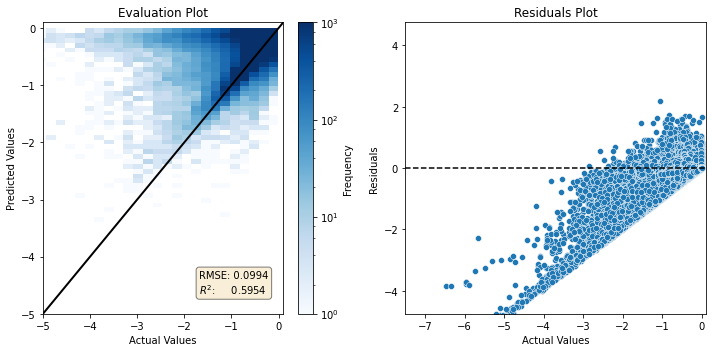

In [52]:
import matplotlib.colors as colors

residuals = y_val_cutoff - y_pred_cutoff

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val_cutoff, y_pred_cutoff))
r2 = r2_score(y_val_cutoff, y_pred_cutoff)

# Print out the metrics
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Create a scatter plot of actual vs predicted values
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Scatter plot with hist2d
hist = ax[0].hist2d(y_val_cutoff, y_pred_cutoff, bins=40, cmap='Blues', norm=colors.LogNorm(vmax=1e3), )
ax[0].set_xlabel('Actual Values')
ax[0].set_ylabel('Predicted Values')
ax[0].set_title('Evaluation Plot')
ax[0].set_xlim(-5, 0.1)
ax[0].set_ylim(-5, 0.1)

ax[0].plot([-5,1], [-5,1], linewidth=2, c='k')
# Create a colorbar for the 2D histogram
cbar = plt.colorbar(hist[3], ax=ax[0])
cbar.set_label('Frequency')

# Set colorbar ticks to be logarithmic
cbar.ax.yaxis.set_major_locator(plt.LogLocator(base=10))
cbar.ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs=(0.2, 0.4, 0.6, 0.8)))

# Add text box with metrics
textstr = f'RMSE: {rmse:.4f}\n$R^2$:     {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.65, 0.15, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

# Create a scatter plot of residuals
sns.scatterplot(x=y_val_cutoff, y=residuals, ax=ax[1])
ax[1].set_xlabel('Actual Values')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals (y_pred - y)')
ax[1].set_xlim(-7.5, 0.1)
ax[1].set_ylim(-4.75, 4.75)
ax[1].hlines(y=0, xmin=-7.5, xmax=0.1, linestyle='--', color='k')
plt.tight_layout()
plt.savefig(f'/home/freimax/msc_thesis/figures/random_forest/IFS/tsubsi/grid_search_model_cutoff_rmse_{rmse:.3f}.png',dpi=150)

---
### Test accuracy of baseline model with threshold cut-oofs

In [74]:
X_val_cutoff1, y_val_cutoff1 = apply_cooling_thr(X_val, y_val, -0.1)

New shape:	(814766, 5)
Old shape:	(6024117, 5)


In [75]:
y_pred_cutoff1 = best_model.predict(X_val_cutoff1)
y_pred_full = best_model.predict(X_val)

In [76]:
y_val_foo  = y_val[y_val<=-0.1]              ## Note, this is the same as y_val_cutoff1
y_pred_foo = y_pred_full[y_val<=-0.1]


In [91]:
print(f'Full data preds: {y_pred_full.shape}')
print(f'Cutoff data preds: {y_pred_cutoff1.shape}')

Full data preds: (6024117,)
Cutoff data preds: (814766,)


In [92]:
## Check if arryas are allclose
if np.allclose(y_pred_cutoff1, y_pred_foo):
    print('Arrays are allclose')

Arrays are allclose


In [28]:
y_preds_cutoff = [] 
y_val_cutoff = []
rmse_cutoffs = []
r2_cutoffs = []

thr_list = [-1, -0.1, -0.01, -0.001, -0.0001, -0.00001]
for i, thr in enumerate(thr_list):
    print(f'Predict and evaluate model with threshold: {thr}:')
    X_val_cutoff, y_validation_cutoff = apply_cooling_thr(X_val, y_val, thr)
    
    y_val_cutoff.append(y_validation_cutoff)
    
    y_pred_cutoff = cutoff_models[i].predict(X_val_cutoff)
    y_preds_cutoff.append(y_pred_cutoff)

    rmse_cutoffs.append( np.sqrt(mean_squared_error(y_validation_cutoff, y_pred_cutoff)))
    r2_cutoffs.append(r2_score(y_validation_cutoff, y_pred_cutoff))


Predict and evaluate model with threshold: -1:
New shape:	(17549, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.1:
New shape:	(814766, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.01:
New shape:	(2741518, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.001:
New shape:	(4007998, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -0.0001:
New shape:	(4854206, 5)
Old shape:	(6024117, 5)
Predict and evaluate model with threshold: -1e-05:
New shape:	(5420201, 5)
Old shape:	(6024117, 5)


In [41]:
preds_cutof_on_fulldata = []
rmse_co_fulldata = []
r2_co_fulldata = []


color_list = ['#000000', '#404040', '#808080', '#C0C0C0', '#FFFFFF']
for i, thr in enumerate(thr_list):
    print(f'Prediction with cut-off model at {thr}')
    pred = cutoff_models[i].predict(X_val)
    
    preds_cutof_on_fulldata.append(pred)
    rmse_co_fulldata.append( np.sqrt(mean_squared_error(y_val, pred)) )
    r2_co_fulldata.append( r2_score(y_val, pred) )

Prediction with cut-off model at -1
Prediction with cut-off model at -0.1
Prediction with cut-off model at -0.01
Prediction with cut-off model at -0.001
Prediction with cut-off model at -0.0001
Prediction with cut-off model at -1e-05


In [34]:
threshold_list = np.arange(-0.00001,-1.1, -0.001)#[-0.1, -0.01, -0.005, -0.001, -0.0001]

rmse_list = []
r2_list = []

for i,thr in enumerate(threshold_list):
    y_val_cutoff = y_val[y_val<=thr] 
    y_pred_cutoff = y_pred[y_val<=thr]

    rmse_list.append(np.sqrt(mean_squared_error(y_val_cutoff, y_pred_cutoff)))
    r2_list.append(r2_score(y_val_cutoff, y_pred_cutoff))
    
    if (i+1) % 100 == 0:
        print(f'Done with step {i+1} of {threshold_list.shape[0]}')
    

Done with step 100 of 1100
Done with step 200 of 1100
Done with step 300 of 1100
Done with step 400 of 1100
Done with step 500 of 1100
Done with step 600 of 1100
Done with step 700 of 1100
Done with step 800 of 1100
Done with step 900 of 1100
Done with step 1000 of 1100
Done with step 1100 of 1100


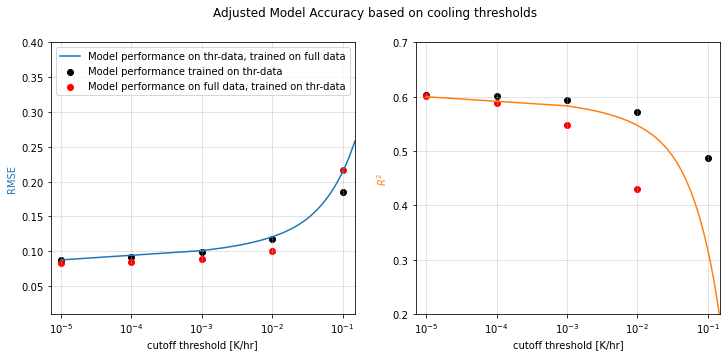

In [55]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Adjusted Model Accuracy based on cooling thresholds', fontsize=12)

ax[0].plot(-threshold_list, rmse_list, c='#1f77b4', label='Model performance on thr-data, trained on full data')
#ax[0].invert_xaxis()
ax[0].set_xlabel('cutoff threshold [K/hr]')
ax[0].set_ylabel('RMSE', c='#1f77b4', fontsize=10)
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(0.01, 0.4)
ax[0].set_xlim(7.1e-6, 0.15)

ax[1].plot(-threshold_list, r2_list, c='#ff7f0e')
#ax[1].invert_xaxis()
ax[1].set_ylabel(r'$R^2$', c='#ff7f0e', fontsize=10)
ax[1].set_xlabel('cutoff threshold [K/hr]')
ax[1].set_xscale('log')
ax[1].set_xlim(7.1e-6, 0.15)
ax[1].set_ylim(0.2, 0.7)

ax[0].scatter([-x for x in thr_list], rmse_cutoffs, c='k', label='Model performance trained on thr-data')
ax[1].scatter([-x for x in thr_list], r2_cutoffs, c='k')

ax[0].scatter([-x for x in thr_list], rmse_co_fulldata, c='red', label='Model performance on full data, trained on thr-data')
ax[1].scatter([-x for x in thr_list], r2_co_fulldata, c='red')

ax[0].legend()

# Adding grid lines
for axes in ax:
    if axes.get_xscale() == 'log':
        axes.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
        axes.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        axes.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=150))
    else:
        axes.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

plt.show()